# 1. Import packages

In [1]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential,load_model
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional
from sklearn.metrics import mean_squared_error
from math import sqrt

# 2. Preprocessing

In [28]:
# past steps
n_steps = 1000
# train test split percent
train_percent = 0.9

In [29]:
# build a univariate sequence
def build_sequence(sequence, n_steps):
    X, y = [], []
    for i in range(len(sequence)):
        end_index = i + n_steps
        # check if end index is over sequence
        if end_index + 1 > len(sequence):
            break
        # get input and output
        seq_x, seq_y = sequence[i:end_index], sequence[end_index]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [30]:
def split_series(series, n_past, n_future):
    #
    # n_past ==> no of past observations
    #
    # n_future ==> no of future observations 
    #
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
        # slicing the past and future parts of the window
        past, future = series[window_start:past_end], series[past_end:future_end]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)

### 2.1 Load dataset

In [31]:
df = pd.read_csv("dataset_GBPUSD_EURUSD.csv")
spread = list(df["SPREAD"])

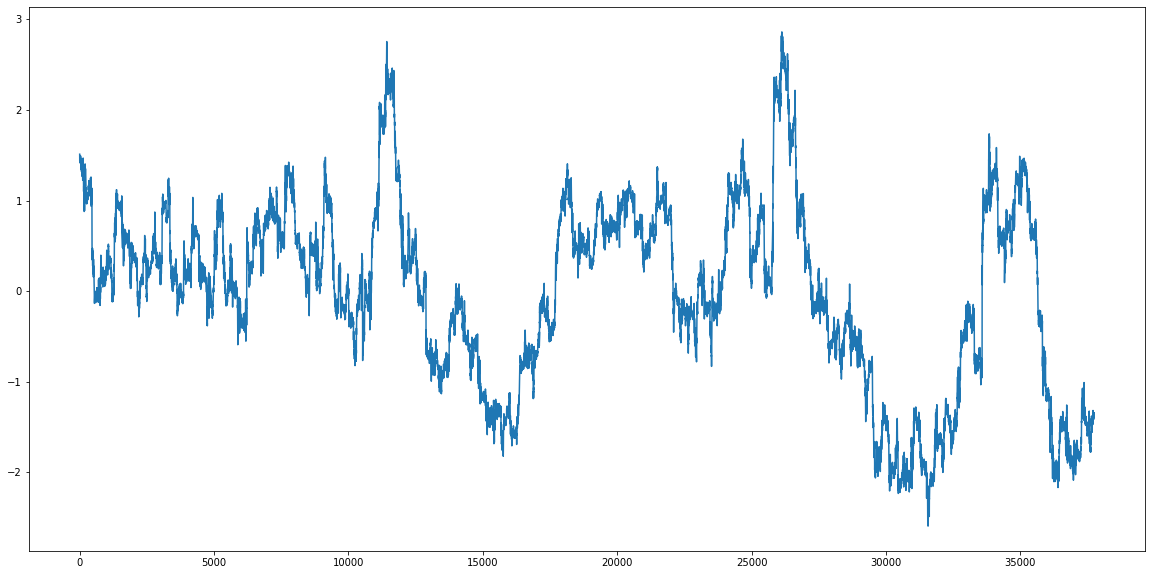

In [32]:
plt.figure(figsize=(20,10))
plt.plot(spread)
plt.show()

### 2.2 Split train and test dataset

In [33]:
train_size = int((len(spread) - n_steps) * train_percent)
train_dataset = spread[n_steps:train_size+n_steps]
test_dataset = spread[train_size + n_steps:]

In [34]:
print(len(spread))
print(train_size)
print(len(train_dataset))
print(len(test_dataset))

37749
33074
33074
3675


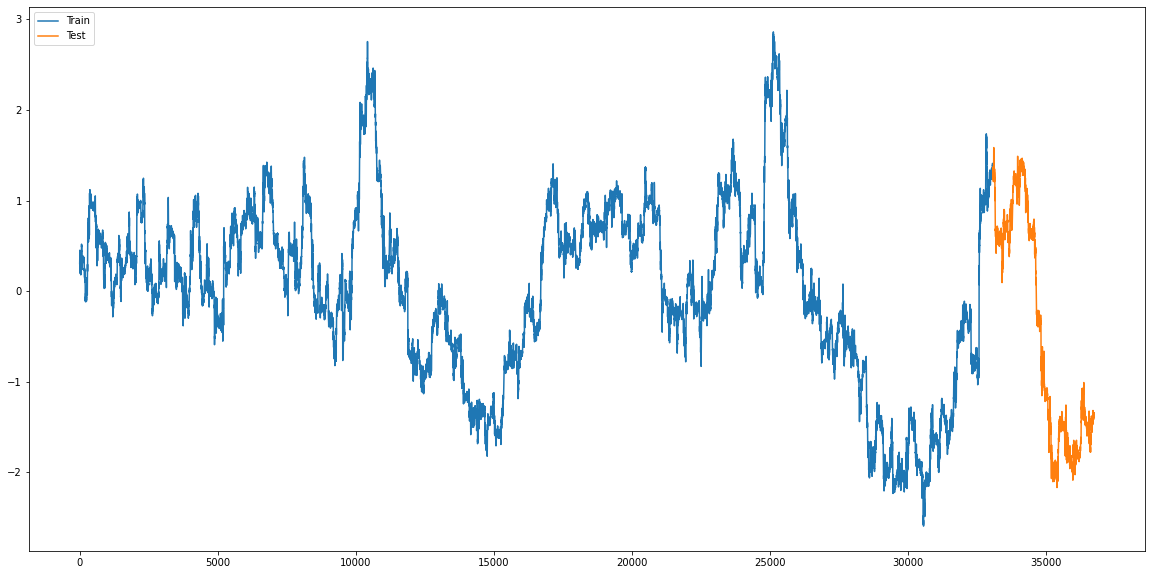

In [35]:
plt.figure(figsize=(20,10))
plt.plot(train_dataset)
plt.plot([None for i in train_dataset] + [x for x in test_dataset])
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### 2.3 Build Sequence

In [36]:
X, y = build_sequence(spread, n_steps)

### 2.4 Split train and test sequence

In [37]:
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [38]:
train_size = int(len(X) * train_percent)
X_train, y_train = X[0:train_size], y[0:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [39]:
print(len(X))
print(len(X_train))
print(len(X_test))

36749
33074
3675


# 3. Build the Model

In [41]:
model = Sequential()
model.add(LSTM(128, activation='tanh', input_shape=(n_steps, n_features)))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [42]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               66560     
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 70,721
Trainable params: 70,721
Non-trainable params: 0
_________________________________________________________________
None


# 4. Train

In [43]:
# fit model
history = model.fit(X_train, y_train, epochs=4)

Epoch 1/4
1034/1034 [==============================] - 1093s 1s/step - loss: 0.0051
Epoch 2/4
1034/1034 [==============================] - 1063s 1s/step - loss: 0.0018
Epoch 3/4
1034/1034 [==============================] - 1067s 1s/step - loss: 0.0015
Epoch 4/4
1034/1034 [==============================] - 1027s 993ms/step - loss: 0.0015


dict_keys(['loss'])


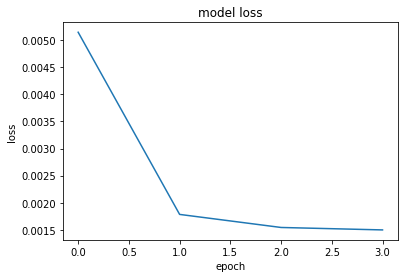

In [44]:
print(history.history.keys())

# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# 5. Evaluate the Model

In [45]:
predictions = []
for x_input in X_test:
    x_input = x_input.reshape((1, n_steps, n_features))
#     print(x_input)
    yhat = model.predict(x_input)
#     print(yhat)
    predictions.append(yhat[0][0])

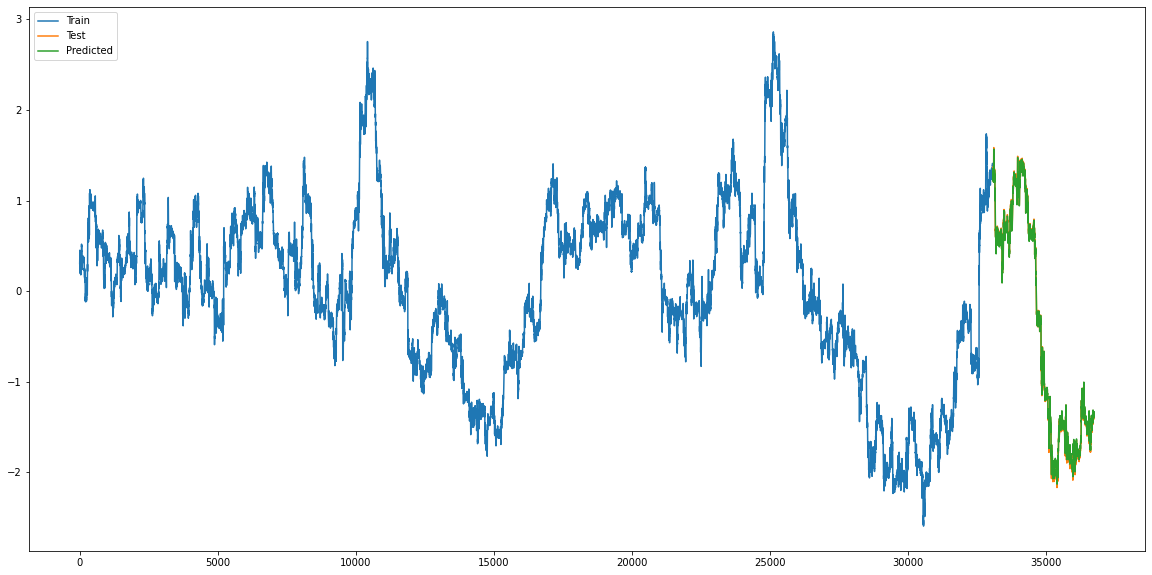

In [46]:
plt.figure(figsize=(20,10))
plt.plot(train_dataset)
plt.plot([None for i in train_dataset] + [x for x in test_dataset])
plt.plot([None for i in train_dataset] + [x for x in predictions])
plt.legend(['Train', 'Test', 'Predicted'], loc='upper left')
plt.show()

In [47]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    return mean_squared_error(actual, predicted , squared=True)

In [48]:
RMSE = evaluate_forecasts(test_dataset, predictions)

In [49]:
RMSE

0.001515749034539421

# 6. Forecasting 7 days(12\*24\*7 = 2016 steps)

In [50]:
prediction_steps = 2016
# demonstrate prediction
forecasted = []

x_input = X_test[-1:]
x_input = np.delete(x_input, 0)
x_input = np.append(x_input, spread[-1])
x_input = x_input.reshape((1, n_steps, n_features))
# print(x_input)

for i in range(prediction_steps):
    yhat = model.predict(x_input)
    forecasted.append(yhat[0][0])
#     print(yhat)
    x_input = np.delete(x_input, 0)    
    x_input = np.append(x_input, yhat[0][0])
    
    x_input = x_input.reshape((1, n_steps, n_features))
#     print(x_input)

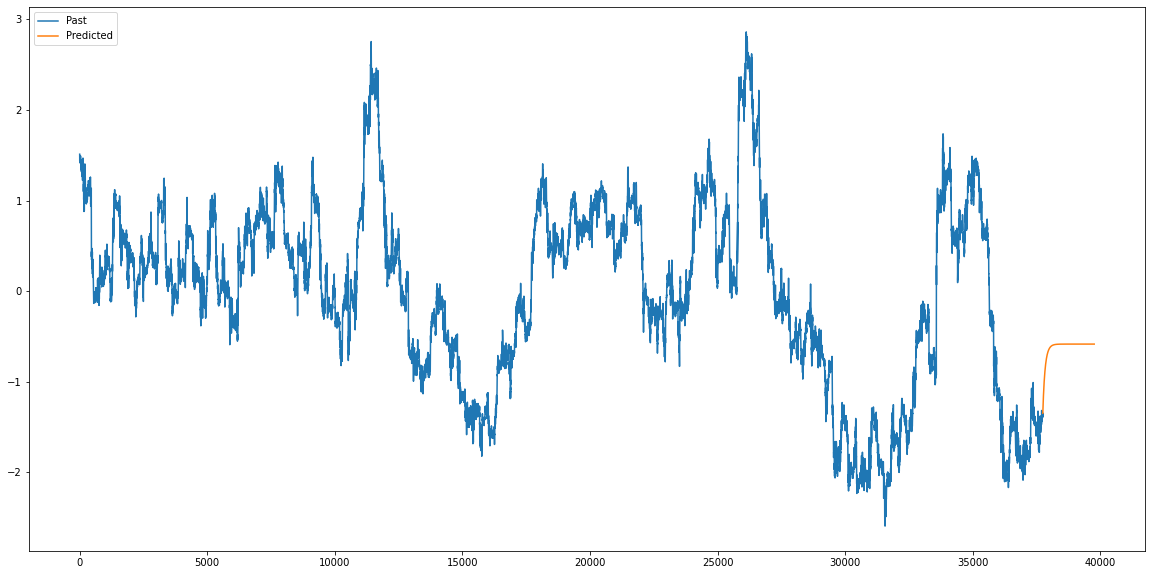

In [51]:
plt.figure(figsize=(20,10))
plt.plot(spread)
plt.plot([None for i in spread] + [x for x in forecasted])
plt.legend(['Past', 'Predicted'], loc='upper left')
plt.show()